# Calculo de estados del Helio mediante el metodo de Hartree Fock

Nicolas Unger

In [2]:
import numpy as np
import sympy as sp
from scipy.linalg import eigh
import matplotlib.pyplot as plt

# Estética
#sp.init_printing()
#%matplotlib inline

In [3]:
nsize = 4

alpha = np.zeros((nsize)) # Alphas de la base gaussiana
Ci = np.zeros((nsize)) # Coeficientes para cada elemento de la base
Efund = []

Spq = np.zeros((nsize,nsize)) # Overlap
Hpq = np.zeros((nsize,nsize)) # Hamiltoniano
Fpq = np.zeros((nsize,nsize)) # Operador de Fock
F2 = np.zeros((nsize,nsize))

In [4]:
# Parametros alpha para construir la funcion de onda

alpha[0] = 0.298073
alpha[1] = 1.242567
alpha[2] = 5.782948
alpha[3] = 38.47497

In [5]:
# Funcion de onda con base gaussiana

def psi(alpha,Ci,x):
    suma = 0
    for i in range(nsize):
        suma += Ci*np.exp(-alpha[i]*x**2)
    return suma

In [6]:
# Funcion para calcular el resultado de las integrales J y K para este caso

def Qprqs(p,r,q,s,alpha):
    num = 2 * np.pi ** (5./2.)
    den1 = (alpha[p]+alpha[q])*(alpha[r]+alpha[s])
    den2 = np.sqrt(alpha[p]+alpha[q]+alpha[r]+alpha[s])
    return num/(den1*den2)

### Genero la matriz de overlap calculando los overlaps de la base Gaussiana

Saco el overlap calculando $\left <\chi_p\middle|\chi_q\right >$

\begin{equation}
\left <\chi_p\middle|\chi_q\right > = \int e^{-\alpha_p r^2} e^{-\alpha_q r^2} d^3\boldsymbol{r} = \int e^{-(\alpha_p + \alpha_q) r^2} d^3\boldsymbol{r}
\end{equation}

In [7]:
# Calculo el overlap entre la base de funciones

r = sp.Symbol('r',positive=True)
a = sp.Symbol('a',positive=True)
b = sp.Symbol('b',positive=True)
z = sp.Symbol('z',positive=True)

# La integral mas la contribucion esferica
sp.simplify(sp.integrate( r**2 * sp.exp(-(a+b)*r**2) , (r,0,sp.oo))) * 4*sp.pi

pi**(3/2)/(a + b)**(3/2)

In [8]:
# Genero la Matriz Spq
# Uso el resultado que me dio integrando el overlap de dos gaussianas.

for p in range(nsize):
    for q in range(p,nsize):
        Spq[p,q] = np.pi**(3./2.) / (alpha[p]+alpha[q])**(3./2.)
        Spq[q,p] = Spq[p,q] # Reflejo los valores ya que Spq es simetrica
Spq

array([[  1.20975063e+01,   2.91187719e+00,   3.71330014e-01,
          2.30637530e-02],
       [  2.91187719e+00,   1.42134692e+00,   2.99025043e-01,
          2.22459699e-02],
       [  3.71330014e-01,   2.99025043e-01,   1.41564997e-01,
          1.89120383e-02],
       [  2.30637530e-02,   2.22459699e-02,   1.89120383e-02,
          8.24921040e-03]])

### Genero la matriz del Hamiltoniano

Hpq esta compuesta por la parte cinetica y la parte potencial

Cinetica:

\begin{equation}
\left <\chi_p\middle| -\frac{1}{2} \nabla^2 \middle|\chi_q\right > = \int e^{-\alpha_p r^2} -\frac{1}{2} \nabla^2 e^{-\alpha_q r^2} d^3\boldsymbol{r}
\end{equation}

In [9]:
# Parte cinectica
# Calculo cuanto da el overlap entre los elementos de la base

sp.simplify(sp.integrate( -0.5 * r**2 * sp.exp(-a*r**2) * (sp.diff(sp.exp(-b*r**2),r,r) + (2/r)*sp.diff(sp.exp(-b*r**2),r)), (r,0,sp.oo))) * 4*sp.pi

3.0*pi**(3/2)*a*b/(a + b)**(5/2)

Potencial:

\begin{equation}
\left <\chi_p\middle| -\frac{Z}{r} \middle|\chi_q\right > = \int e^{-\alpha_p r^2} \left(-\frac{Z}{r}\right) e^{-\alpha_q r^2} d^3\boldsymbol{r}
\end{equation}

In [10]:
# Parte Potencial
# Calculo cuanto da el overlap entre los elementos de la base

sp.simplify(sp.integrate( sp.exp(-(a)*r**2) * -(z*r) * sp.exp(-(b)*r**2), (r,0,sp.oo)) * 4*sp.pi )

-2*pi*z/(a + b)

In [11]:
# Valor medio de la energia cinetica

Z = 2

def Tpq(alpha,p,q):
    num = 3 * np.pi**(3./2.) * alpha[p] * alpha[q]
    den = (alpha[p] + alpha[q])**(5./2.)
    return num/den

def Vpq(alpha,p,q):
    return -(2*Z*np.pi) / (alpha[p] + alpha[q])

for p in range(nsize):
    for q in range(p,nsize):
        Hpq[p,q] = Tpq(alpha,p,q) + Vpq(alpha,p,q)
        Hpq[q,p] = Hpq[p,q]
        
Hpq

array([[ -1.56704407e+01,  -6.05651235e+00,  -1.75071599e+00,
         -3.03635210e-01],
       [ -6.05651235e+00,  -2.40743875e+00,  -8.71147177e-01,
         -2.36061536e-01],
       [ -1.75071599e+00,  -8.71147177e-01,   1.41492399e-01,
          1.29567990e-03],
       [ -3.03635210e-01,  -2.36061536e-01,   1.29567990e-03,
          3.12776396e-01]])

## Comienzo la iteracion

In [68]:
# Construyo el operador de Fock
# Primero hago la suma

for p in range(nsize):
    for q in range(p,nsize):
        suma = 0
        for r in range(nsize):
            for s in range(nsize):
                suma += Qprqs(p,r,q,s,alpha)*Ci[r]*Ci[s]
        F2[p,q] = suma
        F2[q,p] = F2[p,q]
        
F2

array([[ 8.87980689,  2.90944144,  0.498356  ,  0.03674245],
       [ 2.90944144,  1.60583072,  0.40995444,  0.0354791 ],
       [ 0.498356  ,  0.40995444,  0.20639586,  0.03030594],
       [ 0.03674245,  0.0354791 ,  0.03030594,  0.01347282]])

In [69]:
for p in range(nsize):
    for q in range(p,nsize):
        Fpq[p,q] = Hpq[p,q] + F2[p,q]
        Fpq[q,p] = Fpq[p,q]
        
Fpq

array([[-6.79063383, -3.14707091, -1.25235998, -0.26689276],
       [-3.14707091, -0.80160803, -0.46119274, -0.20058244],
       [-1.25235998, -0.46119274,  0.34788826,  0.03160162],
       [-0.26689276, -0.20058244,  0.03160162,  0.32624922]])

In [70]:
# Saco autovectores y autovalores

Energias, Cnuevo = eigh(Fpq,Spq,type=1)
Ci = Cnuevo[:,0]
Ci

array([ 0.14772928,  0.39382958,  0.41081413,  0.26129074])

In [71]:
Energias

array([ -0.9140814 ,   0.58153905,   7.55432944,  61.02868532])

In [72]:
# Normalizo el vector Ci mediante la matriz de overlap

def norm(C,S):
    suma = 0
    for p in range(nsize):
        for q in range(nsize):
            suma += C[p]*S[p,q]*C[q]
    return suma

norma = norm(Ci,Spq)
for i in range(nsize):
    Ci[i] /= np.sqrt(norma)
    
Ci

array([ 0.14772928,  0.39382958,  0.41081413,  0.26129074])

In [73]:
# Verifico si quedo normalizada
norm(Ci,Spq)

1.0000000000000002

In [74]:
# Calculo de la energia del fundamental

E = 0
for p in range(nsize):
    for q in range(nsize):
        E += (2*Hpq[p,q] + F2[p,q])*Ci[p]*Ci[q]
        
Efund.append(E)

In [75]:
Efund

[-3.9885323142089342,
 -2.7290659114788505,
 -2.8907233747431542,
 -2.8455546059830303,
 -2.8577918441290731,
 -2.8544421454201405,
 -2.8553566186148469,
 -2.8551067816451106]

La energia que da con el programa de Fischer es: -2.86167 au

### Grafico de la funcion de onda

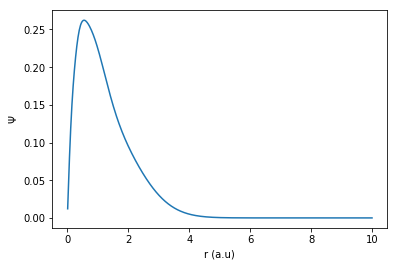

In [76]:
xmin = 0.01
xmax = 10
npts = 500
x = np.linspace(xmin,xmax,npts)

psi1 = np.zeros(npts)

def psi(alpha,Ci,x):
    suma = 0
    for i in range(nsize):
        suma += Ci[i]*np.exp(-alpha[i]*x**2)
    return suma

for i in range(npts):
    psi1[i] = psi(alpha,Ci,x[i])
    
plt.plot(x,x*psi1)
plt.xlabel("r (a.u)")
plt.ylabel("$\Psi$")
plt.show()

In [77]:
# Normalizo la funcion de onda

integral = np.trapz(x**2*psi1**2,x)
psi1 /= np.sqrt(integral)
np.trapz(x**2*psi1**2,x)

1.0000000000000002

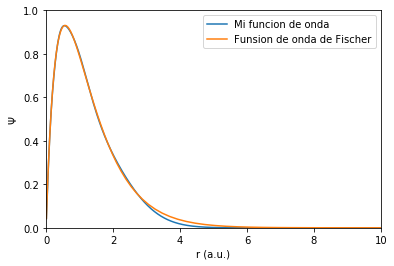

In [78]:
# Importo la funcion de onda obtenida con hf.f (Fischer)
x2,wave1s = np.loadtxt("./hf/Helio/wave.1s",unpack=True)
plt.plot(x,x*psi1,label="Mi funcion de onda")
plt.plot(x2,wave1s,label="Funsion de onda de Fischer")
plt.axis([0,10,0,1])
plt.xlabel("r (a.u.)")
plt.ylabel("$\Psi$")
plt.legend()

plt.show()

### Comparo los valores medios

In [79]:
# Valor medio de r de mi funcion

np.trapz(psi1*psi1*x**3,x)

0.92332199824661731

In [80]:
# Valor medio de r de wave1s (Fischer)

np.trapz(wave1s**2*x2,x2)

0.92787719686497316

In [81]:
# Valor medio de r**2 de mi funcion

np.trapz((psi1*x)**2*x**2,x)

1.1625445981039011

In [82]:
# Valor medio de r**2 de wave1s (Fischer)

np.trapz((wave1s)**2*x2**2,x2)

1.1856000892041505

Las funciones de onda caen bastante bien una arriba de la otra con diferencias lejos del nucleo. Y los valores medios tambien dan bastante parecidos.

# Calculo de Hartree Fock para el ion H-

## Proceso automatizado

In [96]:
# Parametros iniciales

nsize = 4 # Tamano de la base
niter = 15 # Numero de iteraciones

alpha = np.zeros((nsize)) # Alphas de la base gaussiana
Ci = np.zeros((nsize)) # Coeficientes para cada elemento de la base
Efund = [] # Matriz con las energias

Spq = np.zeros((nsize,nsize)) # Overlap
Hpq = np.zeros((nsize,nsize)) # Hamiltoniano
Fpq = np.zeros((nsize,nsize)) # Operador de Fock
F2 = np.zeros((nsize,nsize))

# Para el hidrogeno
alpha[0] = 13.00773
alpha[1] = 2.962079
alpha[2] = 0.444529
alpha[3] = 0.1219492
#alpha[4] = 25.01773
#alpha[5] = 50.00962079
#alpha[6] = 0.00444529
#alpha[7] = 0.011219492

alpha[0] = 0.298073
alpha[1] = 1.242567
alpha[2] = 5.782948
alpha[3] = 38.47497

# Numero atomico
Z = 2

# Funcion para calcular el resultado de las integrales J y K para este caso
def Qprqs(p,r,q,s,alpha):
    num = 2 * np.pi ** (5./2.)
    den1 = (alpha[p]+alpha[q])*(alpha[r]+alpha[s])
    den2 = np.sqrt(alpha[p]+alpha[q]+alpha[r]+alpha[s])
    return num/(den1*den2)

In [97]:
## Setup
# Construyo la matriz de overlap (Spq) y el Hamiltoniano (Hpq)
# Tambien me armo la matriz F2 que voy a necesitar para armar el operador de Fock (Fpq)

def Tpq(alpha,p,q):
    num = 3 * np.pi**(3./2.) * alpha[p] * alpha[q]
    den = (alpha[p] + alpha[q])**(5./2.)
    return num/den

def Vpq(alpha,p,q):
    return -(2*Z*np.pi) / (alpha[p] + alpha[q])

for p in range(nsize):
    for q in range(p,nsize):
        Spq[p,q] = np.pi**(3./2.) / (alpha[p]+alpha[q])**(3./2.)
        Spq[q,p] = Spq[p,q] # Reflejo los valores ya que Spq es simetrica
        Hpq[p,q] = Tpq(alpha,p,q) + Vpq(alpha,p,q)
        Hpq[q,p] = Hpq[p,q]

In [98]:
## Iteracion automatica

for i in range(niter):
    for p in range(nsize):
        for q in range(p,nsize):
            suma = 0
            for r in range(nsize):
                for s in range(nsize):
                    suma += Qprqs(p,r,q,s,alpha)*Ci[r]*Ci[s]
            F2[p,q] = suma
            F2[q,p] = F2[p,q]

    for p in range(nsize):
        for q in range(p,nsize):
            Fpq[p,q] = Hpq[p,q] + F2[p,q]
            Fpq[q,p] = Fpq[p,q]

    Energias, Cnuevo = eigh(Fpq,Spq,type=1)
    Ci = Cnuevo[:,0]

    E = 0
    for p in range(nsize):
        for q in range(nsize):
            E += (2*Hpq[p,q] + F2[p,q])*Ci[p]*Ci[q]

    Efund.append(E)
    
Efund

[-3.9885323142089324,
 -2.7290659114788509,
 -2.8907233747431547,
 -2.8455546059830303,
 -2.8577918441290726,
 -2.854442145420141,
 -2.8553566186148442,
 -2.8551067816451154,
 -2.8551750241854146,
 -2.8551563828287012,
 -2.8551614748866259,
 -2.8551600839385056,
 -2.8551604638898982,
 -2.8551603601023414,
 -2.8551603884529566]

Es el mejor resultado que pude conseguir.

La energia del H- calculada con el programa de Johnson da -0.4879

## Grafico la funcion de onda resultante

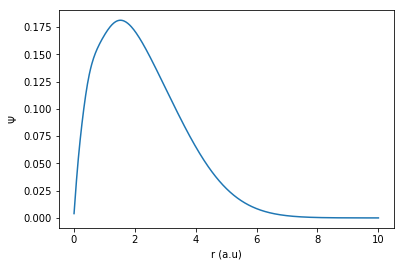

In [86]:
xmin = 0.01
xmax = 10
npts = 500
x = np.linspace(xmin,xmax,npts)

psi2 = np.zeros(npts)

for i in range(npts):
    psi2[i] = psi(alpha,Ci,x[i])
    
plt.plot(x,x*psi2)
plt.xlabel("r (a.u)")
plt.ylabel("$\Psi$")
plt.show()

In [87]:
# Normalizo la funcion de onda

integral = np.trapz(x**2*psi2**2,x)
psi2 /= np.sqrt(integral)
np.trapz(x**2*psi2**2,x)

1.0

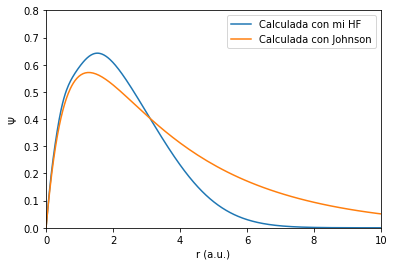

In [88]:
# Comparo con la funcion obtenida del programa de Johnson

x3,wave1s_j = np.loadtxt("./nrhf/wave.1s",unpack=True)
plt.plot(x,x*psi2,label="Calculada con mi HF")
plt.plot(x3,wave1s_j,label="Calculada con Johnson")
plt.axis([0,10,0,0.8])
plt.xlabel("r (a.u.)")
plt.ylabel("$\Psi$")
plt.legend()

plt.show()

### Comparacion de Valores medios

#### Valor medio de r

In [89]:
# Valor medio de r de mi funcion

np.trapz(psi1*psi1*x**3,x)

0.92332199824661731

In [90]:
# Valor medio de r de la funcion de Johnson
np.trapz(wave1s_j**2*x3,x3)

2.5043352505956471

#### Valor medio de $r^2$

In [91]:
np.trapz(psi2*psi2*x**4,x)

4.574751042281628

In [92]:
# Valor medio de r**2 de la funcion de Johnson
np.trapz(wave1s_j**2*x3**2,x3)

9.4125092700301813

Dan bastante distintos los resultados.

Con nuestro algoritmo de Hartree Fock no se pueden reproducir muy bien los resultados del ion H-